In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data=np.load("../data/training_data/OrnsteinUhlenbeck-89/data.npy")

In [3]:
data_1k=np.load("../data/training_data/OrnsteinUhlenbeck-81/data.npy")

In [4]:
data.shape

(10000, 1, 101)

In [5]:
data_1k.shape

(1000, 1, 101)

In [5]:
gen_data=np.load("../data/generated_data/data_ou_newloss.npy")

In [6]:
gen_data_1k=np.load("../data/generated_data/data_ou.npy")

In [7]:
gen_data.shape

(1000, 1, 101)

In [8]:
real_data = torch.tensor(data[:, 0, :])
fake_data = torch.tensor(gen_data[:, 0, :])

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# Compare (visualize) paths
def compare_path(x_real, x_fake, titles=["Real", "Fake"], file_path=None, return_figax=False, dim=0, plot_size=100):
    fig, ax = plt.subplots(1, 2, figsize=[12, 4], sharex=True, sharey=True)
    ax[0].plot(
        x_real[:plot_size].numpy().T,
        alpha=0.3,
        marker="o",
        linewidth=1,
        markersize=1,
    )
    
    ax[1].plot(
        x_fake[:plot_size].numpy().T,
        alpha=0.3,
        marker="o",
        linewidth=1,
        markersize=1,
    )
    
    if titles:
        ax[0].set_title(titles[0])
        ax[1].set_title(titles[1])

    for i in range(2):
        ax[i].set_xlabel("Time")
        ax[i].set_ylabel("Prices")
    if return_figax:
        return fig, ax
    if file_path is None:
        plt.show()
    else:
        plt.savefig(file_path, bbox_inches="tight")
    plt.close()

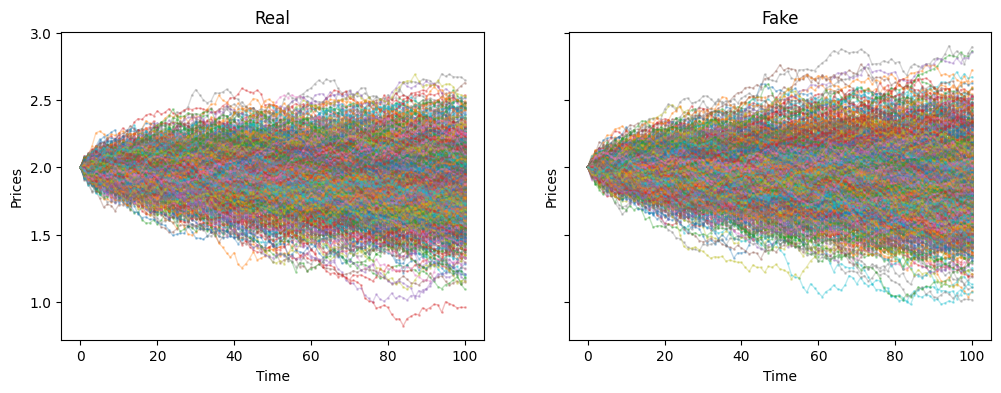

In [24]:
compare_path(real_data,fake_data, plot_size=1000)

In [11]:
# Compare Marginal
def compare_marginal_hist(real_data, fake_data, n_time_slice=4, file_path=None):
    time_range = np.linspace(11, real_data.shape[1] - 1, n_time_slice, dtype=int)
    n_cols = n_time_slice
    fig, ax = plt.subplots(1, n_cols, figsize=[12, 4], sharey=True, sharex=True)
    bins = np.linspace(0, 5, 50)
    for i in range(n_cols):
        axi = ax.flat[i]
        n = time_range[i]
        axi.hist(real_data[:, n], bins=bins, alpha=0.5, label="real")
        axi.hist(fake_data[:, n], bins=bins, alpha=0.3, label="fake")
        axi.set_title(f"Time: {n}")
        axi.legend()
        # axi.set_xlabel("Marginal prices")
    if file_path is None:
        plt.show()
    else:
        plt.savefig(file_path, bbox_inches="tight")
        plt.close(fig)

In [19]:
compare_marginal_hist(real_data[:1000], fake_data,  4, "../data/figures/ou_compare.png" )

In [14]:
# Compare Drift and Volatility
def prices2returns(prices):
    returns = prices[:, 1:] / prices[:, :-1] - 1
    return returns


def compute_volatility(price_path, T):
    return_path = prices2returns(price_path)
    vol2 = torch.sum(return_path**2, dim=1) / T
    vol = torch.sqrt(vol2)
    return vol


def compute_drift(price_path, T):
    return_path = prices2returns(price_path)
    drift = torch.sum(return_path, dim=1) / T
    return drift


def plot_mean_log_prices(data, data_name, axi):
    data = torch.log(data)
    data_mean = torch.mean(data, dim=0)
    data_std = torch.std(data, dim=0)
    axi.plot(data_mean, marker="o", linewidth=1, markersize=1, label=data_name)
    axi.fill_between(
        torch.arange(len(data_mean)),
        data_mean - data_std,
        data_mean + data_std,
        alpha=0.2,
    )


def compare_drift_volatility(real_data, fake_data, T):
    fig, ax = plt.subplots(1, 2, figsize=[12, 4])

    plot_mean_log_prices(real_data, "real", ax[0])
    plot_mean_log_prices(fake_data, "fake", ax[0])
    ax[0].legend()
    ax[0].set_xlabel("Time")
    ax[0].set_title("Log-prices")

    vol = compute_volatility(real_data, T)
    ax[1].hist(vol, bins=100, alpha=0.4, label="real", density=True)
    # sns.kdeplot(vol,ax = ax[1])
    vol = compute_volatility(fake_data, T)
    ax[1].hist(vol, bins=100, alpha=0.4, label="fake", density=True)
    # sns.kdeplot(vol,ax = ax[1])
    ax[1].legend()
    ax[1].set_title("Volatility")
    ax[1].set_xlabel("Volatility")
    plt.show()

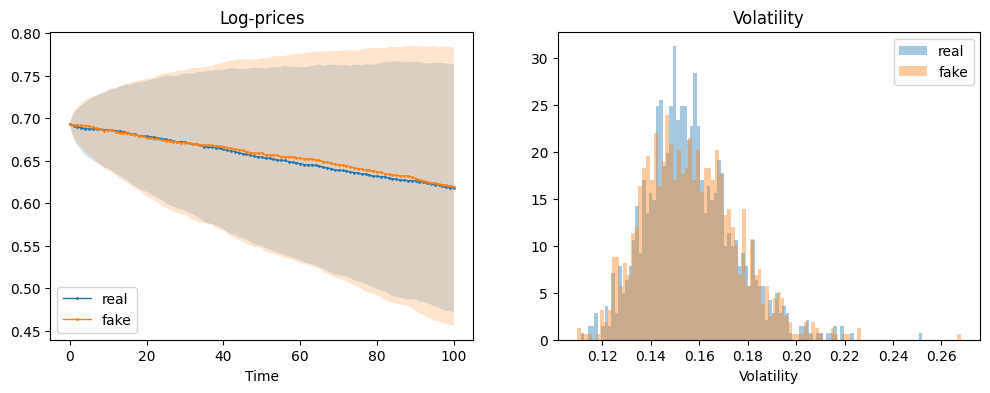

In [21]:
compare_drift_volatility(real_data[:1000],fake_data, 1)

In [16]:
import scipy.stats as  ss
def estimate_OU_params_all_paths(paths, dt=0.01):
    xx=np.concatenate([paths[i,0,:-1] for i in range(len(paths))])
    yy=np.concatenate([paths[i,0,1:] for i in range(len(paths))])
    beta, alpha, _, _, _ = ss.linregress(xx,yy)
    kappa = -np.log(beta)/dt
    theta = alpha/(1-beta)
    res = yy-beta*xx-alpha
    std_resid=np.std(res,ddof=2)
    sigma = std_resid*np.sqrt(2*kappa/(1-beta**2))

    return kappa, theta, sigma

In [17]:
estimate_OU_params_all_paths(data)

(0.31882313045921207, 1.5392295496876447, 0.3004548103732933)

In [18]:
estimate_OU_params_all_paths(gen_data)

(-0.025115275238023805, 6.612564856687402, 0.30018106137233125)

In [31]:
# Estimate parameters for real data
kappa_real,  theta_real, sigma_real, = estimate_OU_params_all_paths(data,0.01)
print(f"Estimated parameters for real paths :")
print(f"  Mean (theta): {theta_real:.5f}, error: {np.abs(theta_real-1.5):.5f}")
print(f"  Volatility (sigma): {sigma_real:.5f}, error: {np.abs(sigma_real-0.3):.5f}")
print(f"  Mean reversion rate (kappa): {kappa_real:.5f}, error {np.abs(kappa_real-0.3):.5f}")

# Estimate parameters for generated data
kappa_fake,  theta_fake, sigma_fake, = estimate_OU_params_all_paths(gen_data,0.01)
print(f"Estimated parameters for fake paths :")
print(f"  Mean (theta): {theta_fake:.5f}, error: {np.abs(theta_fake-1.5):.5f}")
print(f"  Volatility (sigma): {sigma_fake:.5f}, error: {np.abs(sigma_fake-0.3):.5f}")
print(f"  Mean reversion rate (kappa): {kappa_fake:.5f}, error: {np.abs(kappa_fake-0.3):.5f}")

Estimated parameters for real paths :
  Mean (theta): 1.53923, error: 0.03923
  Volatility (sigma): 0.30045, error: 0.00045
  Mean reversion rate (kappa): 0.31882, error 0.01882
Estimated parameters for fake paths :
  Mean (theta): 6.61256, error: 5.11256
  Volatility (sigma): 0.30018, error: 0.00018
  Mean reversion rate (kappa): -0.02512, error: 0.32512


In [24]:
def find(x):
    s_x = np.sum(x[:-1])
    s_y = np.sum(x[1:])
    s_xx = np.sum(x[:-1]**2)
    s_yy = np.sum(x[1:]**2)
    s_xy = np.sum(x[:-1] * x[1:])
    n = len(x)-1
    delta = 0.01

    mu = ((s_y*s_xx)-(s_x*s_xy))/(n*(s_xx-s_xy)-((s_x**2)-s_x*s_y)) # Mean

    theta = -(1/delta)*np.log((s_xy-mu*s_x-mu*s_y+n*mu**2)/(s_xx-2*mu*s_x+n*mu**2)) # Rate

    alpha = np.exp(-theta*delta)
    sigma_h = np.sqrt((1/n)*(s_yy-(2*alpha*s_xy)+((alpha**2)*s_xx)-(2*mu*(1-alpha)*(s_y-alpha*s_x))+(n*(mu**2)*(1-alpha)**2)))

    sigma = np.sqrt((sigma_h**2)*(2*theta/(1-alpha**2))) #Volatility

    return mu, sigma, theta

In [23]:
def find1(x,dt=0.01):
    xx=x[:-1]
    yy=x[1:]
    beta, alpha, _, _, _ = ss.linregress(xx,yy)
    theta = -np.log(beta)/dt 
    mu = alpha/(1-beta)
    res = yy-beta*xx-alpha 
    sigma = np.std(res,ddof=2)*np.sqrt(2*theta/(1-beta**2))
    
    return mu, sigma, theta

In [25]:
# Estimate parameters for real data
kappa_real,  theta_real, sigma_real, = estimate_OU_params_all_paths(data_1k,0.01)
print(f"Estimated parameters for real paths :")
print(f"  Mean (theta): {theta_real:.5f}, error: {np.abs(theta_real-1.5):.5f}")
print(f"  Volatility (sigma): {sigma_real:.5f}, error: {np.abs(sigma_real-0.3):.5f}")
print(f"  Mean reversion rate (kappa): {kappa_real:.5f}, error: {np.abs(kappa_real-0.3):.5f}")

# Estimate parameters for generated data
kappa_fake,  theta_fake, sigma_fake, = estimate_OU_params_all_paths(gen_data_1k,0.01)
print(f"Estimated parameters for fake paths :")
print(f"  Mean (theta): {theta_fake:.5f}, error: {np.abs(theta_fake-1.5):.5f}")
print(f"  Volatility (sigma): {sigma_fake:.5f}, error: {np.abs(sigma_fake-0.3):.5f}")
print(f"  Mean reversion rate (kappa): {kappa_fake:.5f}, error: {np.abs(kappa_fake-0.3):.5f}")

Estimated parameters for real paths :
  Mean (theta): 1.39182, error: 0.10818
  Volatility (sigma): 0.29955, error: 0.00045
  Mean reversion rate (kappa): 0.23204, error: 0.06796
Estimated parameters for fake paths :
  Mean (theta): 1.91881, error: 0.41881
  Volatility (sigma): 0.29428, error: 0.00572
  Mean reversion rate (kappa): 0.11416, error: 0.18584


In [37]:
def estimate_params(x):
    mu=[]
    sigma=[]
    theta=[]
    for i in range(x.shape[0]):
        a,b,c=find(x[i,:])
        mu.append(a)
        sigma.append(b)
        theta.append(c)
    return np.mean(mu), np.std(mu), np.mean(sigma), np.std(sigma), np.mean(theta),np.std(theta) 

In [38]:
def estimate_params2(x):
    mu=[]
    sigma=[]
    theta=[]
    for i in range(x.shape[0]):
        a,b,c=find1(x[i,:])
        mu.append(a)
        sigma.append(b)
        theta.append(c)
    return np.mean(mu), np.std(mu), np.mean(sigma), np.std(sigma), np.mean(theta),np.std(theta)

In [39]:
def estimate_params1(x):
    mu = []
    sigma = []
    theta = []
    for i in range(x.shape[0]):
        a, b, c = find(x[i, :])
        mu.append(a)
        sigma.append(b)
        theta.append(c)
    return np.array(mu), np.array(sigma), np.array(theta) 

In [41]:
real_data = np.load("../data/training_data/OrnsteinUhlenbeck-85/data.npy")[:1000, 0, :]
fake_data = np.load("../data/generated_data/data_ou3.npy")[:, 0, :]
mu_real, _, _,  = estimate_params1(real_data)

mean_real = np.mean(mu_real)
median_real = np.median(mu_real) 
std_real = np.std(mu_real)
min_real = np.min(mu_real)
max_real = np.max(mu_real)

print(f" mean parameter estimate statistics 10k real paths :")
print(f"Mean: {mean_real}")
print(f"Median: {median_real}")
print(f"Maximum: {max_real}")
print(f"Minimum: {min_real}")
print(f"Std: {std_real}")

mu_fake, _, _, = estimate_params1(fake_data)

mean_fake = np.mean(mu_fake)
median_fake = np.median(mu_fake)
std_fake = np.std(mu_fake)
min_fake = np.min(mu_fake)
max_fake = np.max(mu_fake)
print(f" mean parameter estimate statistics 10k fake paths :")
print(f"Mean: {mean_fake}")
print(f"Median: {median_fake}")
print(f"Maximum: {max_fake}")
print(f"Minimum: {min_fake}")
print(f"Std: {std_fake}")

 mean parameter estimate statistics 10k real paths :
Mean: 1.8228019716325625
Median: 1.9044991217878278
Maximum: 8.978051763722853
Minimum: -40.70263987831279
Std: 1.574817328668359
 mean parameter estimate statistics 10k fake paths :
Mean: 1.8200564272841033
Median: 1.917172597717436
Maximum: 17.62826225398244
Minimum: -28.89003756069805
Std: 1.6971108223815783


In [42]:
real_data = data[:, 0, :]
fake_data = gen_data[:, 0, :]
mu_real, _, _,  = estimate_params1(real_data)

mean_real = np.mean(mu_real)
median_real = np.median(mu_real)
std_real = np.std(mu_real)
min_real = np.min(mu_real)
max_real = np.max(mu_real)

print(f" mean parameter estimate statistics 1000 real paths :")
print(f"Mean: {mean_real}")
print(f"Median: {median_real}")
print(f"Maximum: {max_real}")
print(f"Minimum: {min_real}")
print(f"Std: {std_real}")

mu_fake, _, _, = estimate_params1(fake_data)

mean_fake = np.mean(mu_fake)
median_fake = np.median(mu_fake)
std_fake = np.std(mu_fake)
min_fake = np.min(mu_fake)
max_fake = np.max(mu_fake)
print(f" mean parameter estimate statistics 1000 fake paths :")
print(f"Mean: {mean_fake}")
print(f"Median: {median_fake}")
print(f"Maximum: {max_fake}")
print(f"Minimum: {min_fake}")
print(f"Std: {std_fake}")

 mean parameter estimate statistics 1000 real paths :
Mean: 1.8686391116801402
Median: 1.9101092170142473
Maximum: 280.29829854240216
Minimum: -677.7433852197913
Std: 7.75249753515402
 mean parameter estimate statistics 1000 fake paths :
Mean: 1.8200564272841033
Median: 1.917172597717436
Maximum: 17.62826225398244
Minimum: -28.89003756069805
Std: 1.6971108223815783


In [43]:
find(data[:1000,0,:].ravel())

(1.9360451224260642, 0.420814589013233, 2.2107621946871)

In [44]:
find(gen_data[:,0,:].ravel())

(1.9410576360580991, 0.444060531516768, 2.216107991967234)

In [45]:
find1(data[:1000,0,:].ravel())

(1.9360451224276514, 0.4208187555975329, 2.2107621946876113)

In [46]:
find1(gen_data[:,0,:].ravel())

(1.9402178525924672, 0.4439623394157091, 2.2154410884063824)